# EXPLORE Data Science Academy Classification Hackathon

© Explore Data Science Academy

---
### Problem Statement

South Africa is a society that is a very diverse and multicultural country. This is also characterised by it's linguistic diversity. There is plenty of space and freedom for every person to express themselves in any language and/or culture that they are comfortable with. Language is an important aspect of any society and it contributes greatly to the life of the South African society holistically, i.e cultural, econimic, political, social, etc.

As it currently stands, as of May 2023, South Africa has 12 official languages, each equal in legal state. With these number of official language it makes sense that most South African are able to speak at least two official languages. 

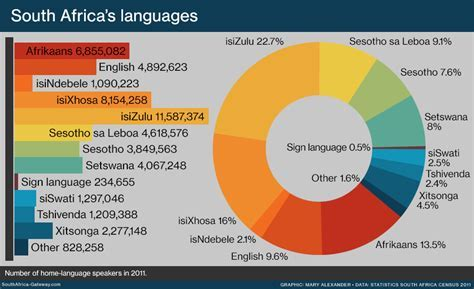

[Image credit](https://southafrica-info.com/arts-culture/11-languages-south-africa/)


With such a multilingual population, it is only obvious that our systems and devices also communicate in multi-languages.

In this challenge, you will take text which is in any of South Africa's 11 Official languages and identify which language the text is in. This is an example of NLP's Language Identification, the task of determining the natural language that a piece of text is written in.

---

<a id="cont"></a>

## Table of Contents

<a href=#one>1. Importing Packages</a>

<a href=#two>2. Loading Data</a>

<a href=#three>3. Exploratory Data Analysis (EDA)</a>

<a href=#four>4. Pre-Processing</a>

<a href=#five>5. Modeling</a>

<a href=#six>6. Model Evaluation and Conclusions</a>


 <a id="one"></a>
## 1. Importing Packages


---


In [1]:
# Importing modules for data science and visualization
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 180 # Quality of all figures in notebook

# NLP Libraries
import re
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tokenize import RegexpTokenizer
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.stem import SnowballStemmer
from os import path
from PIL import Image

# ML Libraries
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk import pos_tag

#ignore warnings
import warnings
warnings.filterwarnings('ignore')

<a id="two"></a>
## 2. Loading the Data


---
 

In [2]:
df_train = pd.read_csv('train_set.csv')
df_test = pd.read_csv('test_set.csv')


In [3]:
dftrain = df_train.copy()
dftest = df_test.copy()

In [4]:
df_train.shape

(33000, 2)

In [5]:
df_train.head()

,lang_id,text
0,xho,umgaqo-siseko wenza amalungiselelo kumaziko ax...
1,xho,i-dha iya kuba nobulumko bokubeka umsebenzi na...
2,eng,the province of kwazulu-natal department of tr...
3,nso,o netefatša gore o ba file dilo ka moka tše le...
4,ven,khomishini ya ndinganyiso ya mbeu yo ewa maana...


In [6]:
df_test.shape

(5682, 2)

In [7]:
df_test.head()

,index,text
0,1,"Mmasepala, fa maemo a a kgethegileng a letlele..."
1,2,Uzakwaziswa ngokufaneleko nakungafuneka eminye...
2,3,Tshivhumbeo tshi fana na ngano dza vhathu.
3,4,Kube inja nelikati betingevakala kutsi titsini...
4,5,Winste op buitelandse valuta.


<a id="three"></a>
## 3. Data Cleaning
<a class="anchor" id="1.1"></a>

In [8]:
#basic info of the training dataset
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33000 entries, 0 to 32999
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   lang_id  33000 non-null  object
 1   text     33000 non-null  object
dtypes: object(2)
memory usage: 515.8+ KB


In [9]:
#basic info of the test dataset
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5682 entries, 0 to 5681
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   index   5682 non-null   int64 
 1   text    5682 non-null   object
dtypes: int64(1), object(1)
memory usage: 88.9+ KB


In [10]:
# check for any missing values in the training dataset
df_train.isnull().sum()

lang_id    0
text       0
dtype: int64

In [11]:
# check for any missing values in the testing dataset
df_test.isnull().sum()

index    0
text     0
dtype: int64

<a id="three"></a>
## 4. Exploratory Data Analysis (EDA)
<a class="anchor" id="1.1"></a>

---



In [12]:
#check our unique y variable
languages = list(np.unique(np.array(df_train.lang_id.to_list())))
languages

['afr', 'eng', 'nbl', 'nso', 'sot', 'ssw', 'tsn', 'tso', 'ven', 'xho', 'zul']

In [13]:
#we check the distribution of the 11 languages
total_dist = df_train.groupby(by = 'lang_id').count()
total_dist

,text
lang_id,
afr,3000
eng,3000
nbl,3000
nso,3000
sot,3000
ssw,3000
tsn,3000
tso,3000
ven,3000


In [14]:
#We collent the entries having fn tags for analysis
have_fn = []
for i in df_test.index:
    txt = df_test.loc[i].text
    if '<fn>' in txt:
        have_fn.append(txt)

In [15]:
#lets print the first two of those special cases
have_fn[:2]

['<fn>(762010101403 AM) 1495 Final Gems Birthing Options_ZULU.txt</fn>',
 '<fn>GOV-ZA.107publicemercycommunicationtrestaffhelpoutatshelterformandeladayEn.2012-02-10.en.txt</fn>']

In [16]:
#how many of those special cases are available
fn_total = len(have_fn)
fn_total

108

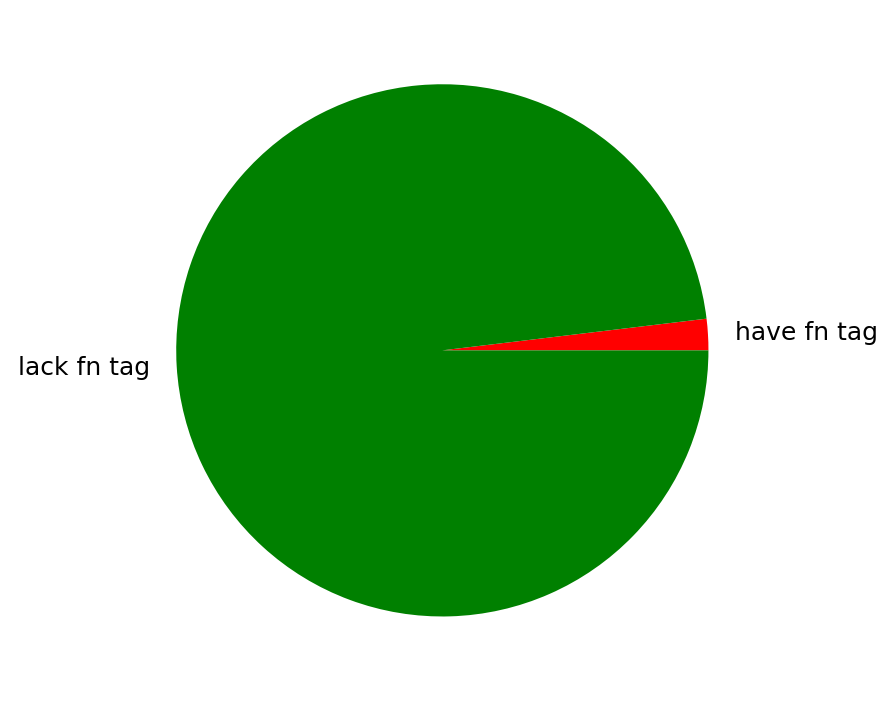

In [17]:
df_test_total = df_test.shape[0]
labels = ['have fn tag','lack fn tag']
values = [fn_total,(df_test_total-fn_total)]
plt.pie(values, labels=labels, colors = ['red','green'])
plt.show()

In [18]:
#lets get the fn total percentage
fail_percentage = np.round((fn_total/df_test_total)*100,2)
fail_percentage

1.9

<a id="three"></a>
## 5. Pre-Processing
---

In [19]:
def train_preprocessing(text):
    
    
    text = text.replace(',','')
    text = text.replace('.',' ')
    text = text.lower() #to lower case
    text = text.replace('\n', ' ') # remove line breaks
    text = text.replace('\@(\w*)', '') # remove mentions
    text = re.sub(r"\bhttps://t.co/\w+", '', text) # remove URLs
    text = re.sub(r'\#', '', text) # remove hashtags. To remove full hashtag: '\#(\w*)'
    text = re.sub(' +', ' ', text) # remove 1+ spaces
    text = re.sub("\n"," ",text)
    text =' '.join(text.split())

    
    return text

In [20]:
#we then apply the text processing to our training data
df_train['text'] = df_train['text'].apply(train_preprocessing)

<a id="three"></a>
## 6. Modelling
---

In [21]:
# Import models
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn import metrics
from sklearn.pipeline import Pipeline
from sklearn.decomposition import LatentDirichletAllocation as LDA
from sklearn.model_selection import GridSearchCV
from sklearn import metrics

# Import vectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

# Assign alias to vectorizer
vect = TfidfVectorizer()

In [22]:
#we devide our features into the x and y as follows
X = df_train['text']
y = df_train['lang_id']

In [23]:
vector = TfidfVectorizer(sublinear_tf=True)
vector = TfidfVectorizer(ngram_range=(1,2), min_df=2)
X =vector.fit_transform(X)

In [24]:
# Splitting the previously defined features and label of your dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [25]:
names = ['Logistic Regression', 'Nearest Neighbors', 
         'Linear SVM', 'RBF SVM',          
         'Decision Tree', 'Random Forest',  'AdaBoost']

In [26]:
classifiers = [
    LogisticRegression(), 
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),    
    AdaBoostClassifier()
]

In [ ]:
results = []

models = {}
confusion = {}
class_report = {}


for name, clf in zip(names, classifiers):    
    print ('Fitting {:s} model...'.format(name))
    run_time = %timeit -q -o clf.fit(X_train, y_train)
    
    print ('... predicting')
    y_pred = clf.predict(X_train)   
    y_pred_test = clf.predict(X_test)
    
    print ('... scoring')
    accuracy  = metrics.accuracy_score(y_train, y_pred)
    precision = metrics.precision_score(y_train, y_pred, average = 'weighted')
    recall    = metrics.recall_score(y_train, y_pred, average = 'weighted')
    
    f1        = metrics.f1_score(y_train, y_pred, average = 'weighted')    
    f1_test   = metrics.f1_score(y_test, y_pred_test, average = 'weighted')    
    
    # Save the results to dictionaries
    models[name] = clf    
    confusion[name] = metrics.confusion_matrix(y_train, y_pred)
    class_report[name] = metrics.classification_report(y_train, y_pred)
    
    results.append([name, accuracy, precision, recall, f1, f1_test, run_time.best])

    
results = pd.DataFrame(results, columns=['Classifier', 'Accuracy', 'Precision', 'Recall', 'F1 Train', 'F1 Test', 'Train Time'])
results.set_index('Classifier', inplace= True)

print ('... All done!')

Fitting Logistic Regression model...
... predicting
... scoring
Fitting Nearest Neighbors model...
... predicting
... scoring
Fitting Linear SVM model...
... predicting
... scoring
Fitting RBF SVM model...


<a id="three"></a>
## 6. Model Evaluation and Conclusions
